# Using Classification Modeling and Reddit to Find Emotive Words

## Problem Statement

As complex platforms provide online communities for many individuals and societies manipulation and propaganda has become an ever increasing problem. This project aims to begin the process of better understanding the meaning of words and their effectiveness in conveying emotion. We focus on emotion as the current consensus on human decision making is that emotions is more persuasive than logic. This does not mean that logic is worthless or unnecessary but that it is more effective to use emotional persuasion which is supported by logic. [source 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4050437/) [source 2](https://customerthink.com/neuroscience-confirms-we-buy-on-emotion-justify-with-logic-yet-we-sell-to-mr-rational-ignore-mr-intuitive/)

In order to begin understanding emotions in words our first step is to create a list of words that convey emotion. To attempt to do this we will use classification models and natural language processing to find words that help separate bodies of text from two very distinct subreddits, [/r/AskPhysics](https://www.reddit.com/r/AskPhysics/) and [/r/Poetry](https://www.reddit.com/r/Poetry/). Most submissions on the /r/AskPhysics subreddit are purely related to understanding concepts in physics and therefore are, for the most part, devoid of emotions. Poetry on the other hand often requires the use of a few words to convey complex feelings. Additionally, /r/Poetry includes tagging on submissions that allow us to only select submissions that have been tagged poems.

Using Classification Modeling we will try to create a high scoring model, accuracy, that we can then pull feature names (words) and feature importance. Then using feature importance we will select words that most influence the classification model and check if these words convey emotion. Then for lack of a better method, we will see if the results are intuitive.

## Content
- [Background](#Background)
- [Setup](#Setup)
- [Data Collection](#Data-Collection)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Classification Modeling](#Classification-Modeling)
- [Evaluating Features](#Evaluating-Features)
- [Results & Conclusion](#Results-&-Conclusion)

## Background

Machine learning and emotional recognition is very difficult, however, in recent years there has been a [heavy focus on sentiment analysis](https://link.springer.com/article/10.1007/s10462-021-09973-3). This has become an ever increasing need as there have been high profile issues within online communities in regards to manipulation and emotion. Some examples being Facebook and Cambridge Analytica and the United States elections and foreign actors within the twitter ad space.

In marketing the consensus opinion is that emotions trump logic. This does not mean that logic is useless but that emotion is often more important than logic when trying to convince consumers to purchase a product. This does not mean, however, that emotion lacks logic or is a poor method of decision making. The current opinions seem to be that emotion is a very complicated system that encompasses intuition and enormous amounts of data processing.

Sources/Literature on Emotions:
* [effect of emotions on logic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4050437/)
* [emotion and jury deliberation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2416818)
* [emotion and b2b sales](https://www.b2bmarketing.net/en/resources/blog/why-b2b-marketing-needs-emotional-storytelling)
* [emotion and marketing 1](https://customerthink.com/neuroscience-confirms-we-buy-on-emotion-justify-with-logic-yet-we-sell-to-mr-rational-ignore-mr-intuitive/)
* [emotion and marketing 2](https://www.mycustomer.com/marketing/strategy/how-research-proves-emotion-is-more-powerful-than-logic-in-marketing)

Reddit:

Reddit is a platform that has created a multitude of communities. Many of these communities are built on visual media, however, some communities such as /r/askscience or /r/history are heavily text based. Additionally, most subreddits, at least the popular ones, are moderated to some degree, we assume heavily.

## Setup

In [1]:
import datetime
import random
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              VotingClassifier,)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from spacy.lang.en import English

%matplotlib inline

### Functions

In [2]:
# PushShift
def get_submissions(subreddit, n=5_000, sleep=1):
    """
    Uses pushshift api to get submissions from a subreddit.
    :param subreddit: Name of subreddit, string.
    :param n: Get at least n submissions. Optional, default: 5_000.
    :param sleep: Delay between each api request.
    :return: pandas DataFrame.
    """
    params = {
        'subreddit': subreddit,
        'size': 100  # 100 is the max size
    }
    attempts = 0  # count to limit if successful requests returns nothing
    all_submissions = []  # list of result data from pushshift
    while len(all_submissions) < n and attempts < 2 * n / 100:
        res = requests.get('https://api.pushshift.io/reddit/search/submission',
                           params)
        attempts += 1
        if res.status_code == 200:
            submissions = res.json()['data']
            if submissions:
                all_submissions += submissions
                # do not want duplicate data
                params['before'] = min([submission['created_utc'] 
                                        for submission in submissions])
        time.sleep(sleep)
    return pd.DataFrame(all_submissions)

In [3]:
# Data Cleaning
def clean_submission_df(df_o):
    """
    Takes DataFrame and drops na values, duplicates, empty 'selftext' columns,
    and pinned content.
    :param df_o: pandas Dataframe to clean.
    :return: pandas DataFrame.
    """
    df_ = df_o.copy()
    df_.dropna(inplace=True)  # cannot fix na values of selftext
    df_.drop_duplicates(subset=['id'], inplace=True)  # init check
    df_ = df_[~df_['selftext'].isin(['[deleted]', '[removed]'])]
    df_ = df_[~df_['pinned']]  # pinned content is most likely rules/faq/etc
    return df_


# cleans text using all cleaning functions
def clean_text(X, word_list=[]):
    # order is very important
    X = replace_url(X)
    X = replace_amp(X)
    X = replace_nbsp(X)
    X = replace_newline(X)
    X = replace_nonalpha(X)
    X = replace_small_words(X)
    X = remove_words(X, word_list)
    return X


def replace_url(X):
    return X.str.replace('http\S+|www.\S+', '', case=False)  # ref 1


def replace_amp(X):
    return X.str.replace('&amp;', ' ', regex=False)


def replace_nbsp(X):
    return X.str.replace('nbsp;', ' ', regex=False)


def replace_newline(X):
    return X.str.replace('\n', ' ', regex=False)


def replace_nonalpha(X):
    return X.str.replace('[^a-zA-Z ]', ' ')  # ref 2 


def replace_small_words(X):
    return X.str.replace(r'\b[a-zA-Z]{1,3}\b', '')  # ref 3


def remove_words(X, words=[]):
    for word in words:
        X = X.str.replace(word, '')
    return X

# 1) https://stackoverflow.com/questions/45395676/remove-a-url-row-by-row-from-a-large-set-of-text-in-python-panda-dataframe
# 2) https://stackoverflow.com/questions/3210393/how-do-i-remove-all-non-alphanumeric-characters-from-a-string-except-dash
# 3) https://stackoverflow.com/questions/24463814/php-regex-remove-words-less-than-3-characters/24463828

In [4]:
# stem series of text
def stem_X(X):
    nlp = English()
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(w.text) for w in nlp(t)]) 
            for t in X]
    

# lemmatize a series of text
def lemmatize_X(X):
    nlp = English()
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(w.text) for w in nlp(t)]) 
                for t in X]


# print grid search scores
def print_gs(gs, X_train, X_test, y_train, y_test):
    print('Training Score: ', gs.score(X_train_lem, y_train_lem))
    print('Cross Val Score: ', gs.best_score_)
    print('Test Score: ', gs.score(X_test_lem, y_test_lem))
    print('Best Params: ', gs.best_params_ )

### Pipelines

In [5]:
# pipelines to be used for modeling and in grid searching
pipe_ada = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('ada', AdaBoostClassifier())
])

pipe_gb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('gb', GradientBoostingClassifier())
])

pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

pipe_tree = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('tree', DecisionTreeClassifier())
])

## Data Collection

### Pushshift

Pull data and store in csvs.

**Commented out to prevent overwriting of data & addition wait time on load**

In [6]:
# df = get_submissions('poetry', n=15_000)  # less usable data
# df.to_csv('./data/poetry.csv', index=False)

In [7]:
# df = get_submissions('AskPhysics')
# df.to_csv('./data/askphysics.csv', index=False)

## Data Cleaning

In [8]:
# load the data
askphysics_df = pd.read_csv('./data/askphysics.csv')
poetry_df = pd.read_csv('./data/poetry.csv')

C:\Users\Sam\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (80) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
askphysics_df.shape, poetry_df.shape

((5000, 72), (15000, 81))

Check columns that are in both datasets.

In [10]:
set(askphysics_df.columns) | set(poetry_df.columns)

{'all_awardings',
 'allow_live_comments',
 'author',
 'author_cakeday',
 'author_flair_background_color',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_template_id',
 'author_flair_text',
 'author_flair_text_color',
 'author_flair_type',
 'author_fullname',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'banned_by',
 'can_mod_post',
 'contest_mode',
 'created_utc',
 'crosspost_parent',
 'crosspost_parent_list',
 'domain',
 'edited',
 'full_link',
 'gallery_data',
 'gilded',
 'gildings',
 'id',
 'is_crosspostable',
 'is_gallery',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'link_flair_background_color',
 'link_flair_css_class',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media',
 'media_embed',
 'media_metadata',
 'media_only',
 'no_follow',
 'num_comments',
 'num_crossposts',
 'over_18',
 'parent_white

In [11]:
# select columns of interest
cols = ['id', 'created_utc', 'num_comments', 'pinned', 'score', 'title', 
        'selftext', 'subreddit']

### Cleaning before Concatenating Subreddits

Want to make sure we end up with a relatively balanced dataset. Some cleaning is different between the subreddits.

In [12]:
askphysics_df = askphysics_df[cols]
poetry_df = poetry_df[cols]

In [13]:
askphysics_df.isna().sum()

id                0
created_utc       0
num_comments      0
pinned            0
score             0
title             0
selftext        415
subreddit         0
dtype: int64

In [14]:
poetry_df.isna().sum()

id                 0
created_utc        0
num_comments       0
pinned             0
score              0
title              0
selftext        3269
subreddit          0
dtype: int64

In [15]:
askphysics_df['selftext'].value_counts()[:3]

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [16]:
poetry_df['selftext'].value_counts()[:3]

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           4912
[deleted]                                                                                                                                                      

**Cleaning to perform:**
* drop duplicates
* drop na values
* remove '[deleted]' and '[removed]' values from 'selftext' column
* drop pinned submissions

In [17]:
askphysics_df = clean_submission_df(askphysics_df)
poetry_df = clean_submission_df(poetry_df)

# poem submissions are prefaced with a '[POEM]' in the title
# specific only to /r/Poetry
poetry_df = poetry_df[poetry_df['title'].str.contains('[POEM]', regex=False)]

In [18]:
askphysics_df.shape, poetry_df.shape

((4378, 8), (4320, 8))

**Combine data into one DataFrame**

In [19]:
df = pd.concat([askphysics_df, poetry_df], ignore_index=True)

In [20]:
# check balance of target
df['subreddit'].value_counts(normalize=True)
df.to_csv('./data/submissions.csv', index=False)

### Cleaning after Concatenating Subreddits

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8698 entries, 0 to 8697
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            8698 non-null   object
 1   created_utc   8698 non-null   int64 
 2   num_comments  8698 non-null   int64 
 3   pinned        8698 non-null   bool  
 4   score         8698 non-null   int64 
 5   title         8698 non-null   object
 6   selftext      8698 non-null   object
 7   subreddit     8698 non-null   object
dtypes: bool(1), int64(3), object(4)
memory usage: 484.3+ KB


In [22]:
df.head()

,id,created_utc,num_comments,pinned,score,title,selftext,subreddit
0,ngqojf,1621484843,0,False,1,What’s the answer to this question,An amount of water of 1.5kg is heated from 20c...,AskPhysics
1,ngqf8b,1621484039,0,False,1,Redirect EMF Rafiation,A portion of my living room is bombarded with ...,AskPhysics
2,ngpwpf,1621482473,0,False,1,"Other states/phases of matter (solid, liquid, ...","Every time that I see discussion of plasma, it...",AskPhysics
3,ngosi3,1621479126,0,False,1,The mathematics of quantum field theory,"Several branches of physics have a ""distinct"" ...",AskPhysics
4,ngonop,1621478732,0,False,1,"With regards to recent ""UAP""/""UFO"" sightings (...","So, for reference and background information, ...",AskPhysics


In [23]:
df.tail()

,id,created_utc,num_comments,pinned,score,title,selftext,subreddit
8693,i0szhp,1596139122,1,False,1,"[POEM] ""On The Farm"" - R. S. Thomas",There was Dai Puw. He was no good.\nThey put h...,Poetry
8694,i0ssmv,1596138456,0,False,1,[POEM] E.E. Cummings quote,To be nobody-but-yourself— in a world which is...,Poetry
8695,i0qqk2,1596131812,10,False,1,[POEM] Shoveling Snow with Buddha by Billy Col...,In the usual iconography of the temple or the ...,Poetry
8696,i0ocg6,1596123957,2,False,1,"[POEM] ""Jamesian"" by Thom Gunn",Their relationship consisted \nIn discussing ...,Poetry
8697,i0nvl8,1596122380,15,False,1,"[POEM] ""On the Necessity of Sadness"" - Mikael ...",Let me tell you about longing.\n\nLet me presu...,Poetry


Information to drop before nlp:
* title column, too informative
* from 'selftext' column
    * urls
    * numbers (poems usually do not have numbers)
    * punctuation, not interested, care more about word distinctions

In [24]:
# cleanup not added to pipeline as stem and lemmatize come afterwards and 
# would add a lot of time to modeling and grid searching / take too much
# memory
words_to_remove = ['physics', 'physicist']
df['selftext'] = clean_text(df['selftext'], words_to_remove)

## Exploratory Data Analysis

In [25]:
df.describe()

,created_utc,num_comments,score
count,8.698000e+03,8698.000000,8698.000000
mean,1.612636e+09,4.662566,2.389630
std,6.958321e+06,8.891594,17.170467
min,1.596122e+09,0.000000,0.000000
25%,1.608251e+09,0.000000,1.000000
50%,1.613969e+09,2.000000,1.000000
75%,1.618589e+09,5.000000,1.000000
max,1.621541e+09,216.000000,621.000000


**Length and Word Count of selftext Column**

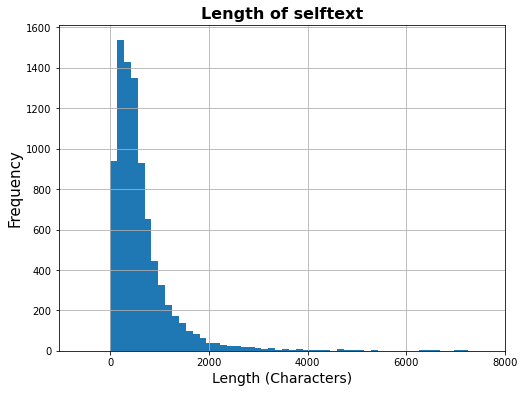

In [26]:
df['selftext_length'] = [len(body) for body in df['selftext']]

plt.figure(figsize=(8, 6))
df['selftext_length'].hist(bins=150)
plt.xlim(right=8_000);
plt.title('Length of selftext', fontweight='bold', fontsize=16)
plt.xlabel('Length (Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=15);

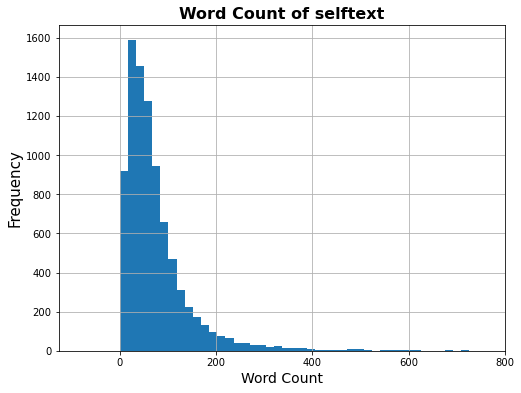

In [27]:
df['selftext_word_count'] = [len(body.split()) for body in df['selftext']]

plt.figure(figsize=(8, 6))
df['selftext_word_count'].hist(bins=150)
plt.xlim(right=800);
plt.title('Word Count of selftext', fontweight='bold', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Frequency', fontsize=15);

**Most Common Words**

In [28]:
cvec = CountVectorizer(stop_words='english')
X_cvec = cvec.fit_transform(df['selftext'])
cvec_df = pd.DataFrame(X_cvec.toarray(), columns=cvec.get_feature_names())

In [29]:
cvec_df.sum()

aaabsolutely    1
aaah            1
aardvarks       1
aarhus          2
aaron           1
               ..
zvijezde        2
zvijezdi        1
zvjezdan        1
zvon            1
zwiebach        1
Length: 36945, dtype: int64

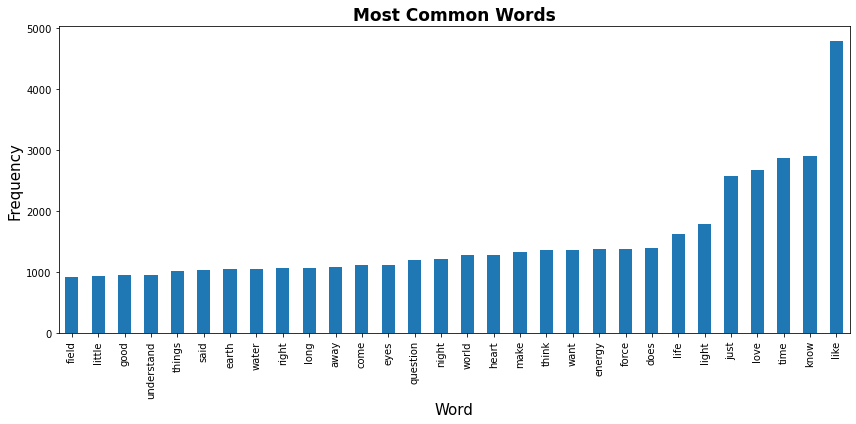

In [30]:
plt.figure(figsize=(12, 6))
cvec_df.sum().sort_values()[-30:].plot(kind='bar')
plt.title('Most Common Words', fontweight='bold', fontsize=17)
plt.xlabel('Word', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.tight_layout();

In [31]:
cvec_df['subreddit'] = df['subreddit']

In [32]:
cvec_df[cvec_df['subreddit'] == 'Poetry'].sum()

aaabsolutely    0
aaah            1
aardvarks       1
aarhus          2
aaron           1
               ..
zvijezde        2
zvijezdi        1
zvjezdan        1
zvon            1
zwiebach        0
Length: 36945, dtype: object

## Classification Modeling

Only interested in the words that make up the body of the submission.

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**selftext**|*object*|reddit|Body of the submission, text, which will be vectorized into many columns.| 
|**subreddit**|*object*|reddit|Name of subreddit where submission was posted.| 

In [33]:
target = 'subreddit'

X = df['selftext']
y = df[target].map({'AskPhysics': 0, 'Poetry': 1})

In [34]:
# test both stemming and Lemmatisation
# separated because if included in gridsearch, takes forever
X_lem = lemmatize_X(X)
X_stem = stem_X(X)

**Baseline**

In [35]:
y.value_counts(normalize=True).max() 

0.5033340997930559

The baseline for model would be to predict that all submissions were posted on '/r/AskPhysics'. This model would have an accuracy score of ~.503.

**Train Test Split Data**

In [36]:
# test both stemming and Lemmatisation
X_train_lem, X_test_lem, y_train_lem, y_test_lem = \
train_test_split(X_lem, y,
                 stratify=y,
                 test_size=0.2,
                 random_state=73)

X_train_stem, X_test_stem, y_train_stem, y_test_stem = \
train_test_split(X_stem, y,
                 stratify=y,
                 test_size=0.2,
                 random_state=73)

**DecisionTreeClassifier**

In [37]:
grid = {
    # 'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [40],
    'tfidf__max_df': [0.40, 0.50],
    'tfidf__norm': ['l2', 'l1'],
    'tree__max_depth': [5, 10, 15]
}
gs_dt_lem = GridSearchCV(pipe_tree, param_grid=grid, n_jobs=-1, cv=10)
gs_dt_lem.fit(X_train_lem, y_train_lem)
print_gs(gs_dt_lem, X_train_lem, X_test_lem, y_train_lem, y_test_lem)

Training Score:  0.8866053463638977
Cross Val Score:  0.8386033242371621
Test Score:  0.8718390804597701
Best Params:  {'tfidf__max_df': 0.4, 'tfidf__max_features': 40, 'tfidf__norm': 'l2', 'tree__max_depth': 15}


In [38]:
grid = {
    # 'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [40],
    'tfidf__max_df': [0.61, 0.62],
    'tfidf__norm': ['l2', 'l1'],
    'tree__max_depth': [13],  # [12, 13, 14]
    'tree__class_weight': [None, 'balanced']
}
gs_dt_stem = GridSearchCV(pipe_tree, param_grid=grid, n_jobs=-1, cv=10)
gs_dt_stem.fit(X_train_stem, y_train_stem)
print_gs(gs_dt_stem, X_train_stem, X_test_stem, y_train_stem, y_test_stem)

Training Score:  0.8437769473986778
Cross Val Score:  0.8469370710328288
Test Score:  0.8373563218390805
Best Params:  {'tfidf__max_df': 0.62, 'tfidf__max_features': 40, 'tfidf__norm': 'l2', 'tree__class_weight': 'balanced', 'tree__max_depth': 13}


The lemmatized text model seems to always be overfit as the training score is much greater than the cross val score and as the max_depth parameter also chooses the highest available value. On the other hand the stemmed text model settles at a max_depth of 13 while also not being overfit as the training score is below the cross val score. However, the test score is much lower than both the training and cross val score, which may be due to a bad test sample.

**RandomForestClassifier**

In [39]:
grid = {
    'tfidf__max_features': [40],
    'tfidf__max_df': [0.64, 0.65],
    'tfidf__norm': ['l2', 'l1'],
    'rf__max_depth': [10],  # [24]
    'rf__class_weight': [None, 'balanced']
}
gs_rf_lem = GridSearchCV(pipe_rf, param_grid=grid, n_jobs=-1, cv=10)
gs_rf_lem.fit(X_train_lem, y_train_lem)
print_gs(gs_rf_lem, X_train_lem, X_test_lem, y_train_lem, y_test_lem)

Training Score:  0.8696464501293475
Cross Val Score:  0.854413090217481
Test Score:  0.8637931034482759
Best Params:  {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'tfidf__max_df': 0.64, 'tfidf__max_features': 40, 'tfidf__norm': 'l2'}


In [40]:
grid = {
    'tfidf__max_features': [40],
    'tfidf__max_df': [0.60],
    'tfidf__norm': ['l2', 'l1'],
    'rf__max_depth': [24, 25, 26],
    'rf__class_weight': [None, 'balanced']
}
gs_rf_stem = GridSearchCV(pipe_rf, param_grid=grid, n_jobs=-1, cv=10)
gs_rf_stem.fit(X_train_stem, y_train_stem)
print_gs(gs_rf_stem, X_train_stem, X_test_stem, y_train_stem, y_test_stem)

Training Score:  0.8661971830985915
Cross Val Score:  0.87726101877119
Test Score:  0.8580459770114942
Best Params:  {'rf__class_weight': 'balanced', 'rf__max_depth': 24, 'tfidf__max_df': 0.6, 'tfidf__max_features': 40, 'tfidf__norm': 'l1'}


There is a similar pattern occurs as the lemmatized text model seems to be overfit as training score is greater than the cross val score while for the stemmed text model the training score is less than the cross val score. It seems it would be best to move forward using the stemmer.

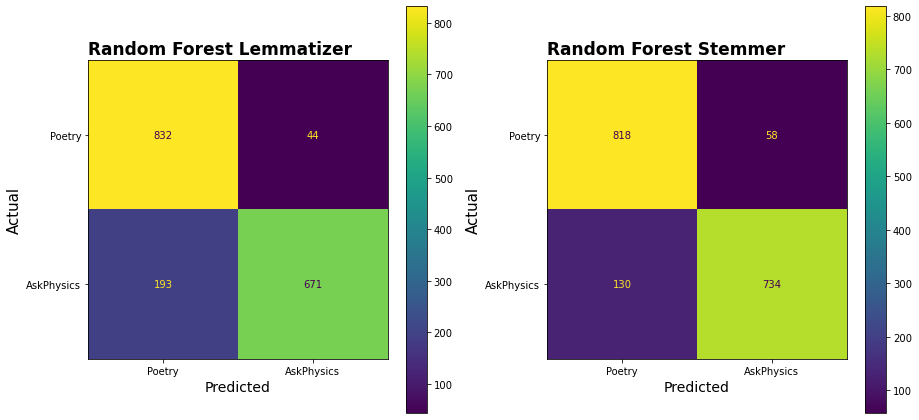

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

metrics.plot_confusion_matrix(gs_rf_lem, X_test_lem, y_test_lem, ax=ax[0],
                              display_labels=['Poetry', 'AskPhysics'])
ax[0].set_title('Random Forest Lemmatizer', 
                loc='left', fontweight='bold', fontsize=17)
ax[0].set_xlabel('Predicted', fontsize=14)
ax[0].set_ylabel('Actual', fontsize=15)

metrics.plot_confusion_matrix(gs_rf_stem, X_test_stem, y_test_stem, ax=ax[1],
                              display_labels=['Poetry', 'AskPhysics'])
ax[1].set_title('Random Forest Stemmer', 
          loc='left', fontweight='bold', fontsize=17)
ax[1].set_xlabel('Predicted', fontsize=14)
ax[1].set_ylabel('Actual', fontsize=15)
plt.tight_layout();

**Interpretation:**

The two figures above show the confusion matrix plots for the random forest classifier model. The left figure displays the results for a model that was fit to a lemmatized dataset while the right figure shows the results for a model that was fit to a stemmed dataset. There are less Type I and Type II errors on the stemmed data model, therefore, it seems best to move forward with using stemming in this instance.

**VotingClassifier**

In [42]:
vote = VotingClassifier([
    ('ada', pipe_ada),
    ('gb', pipe_gb),
    ('rf', pipe_rf)
])

grid = {
    'ada__ada__n_estimators': [50, 100],
    'ada__ada__learning_rate': [1],  # [0.1, 0.2, 0.3],
    'gb__gb__max_features': ['sqrt'],  # ['sqrt', 'log2'],
    'gb__gb__max_depth': [3],  # [1, 2, 3],
    'rf__tfidf__max_features': [50],
    'rf__tfidf__max_df': [0.60],
    'rf__tfidf__norm': ['l2', 'l1'],
    'rf__rf__max_depth': [3, 4, 5]
}

gs_vote = GridSearchCV(vote, param_grid=grid, n_jobs=-1)
gs_vote.fit(X_train_stem, y_train_stem)
print_gs(gs_vote, X_train_stem, X_test_stem, y_train_stem, y_test_stem)

Training Score:  0.933314170738718
Cross Val Score:  0.946104886090384
Test Score:  0.9304597701149425
Best Params:  {'ada__ada__learning_rate': 1, 'ada__ada__n_estimators': 100, 'gb__gb__max_depth': 3, 'gb__gb__max_features': 'sqrt', 'rf__rf__max_depth': 4, 'rf__tfidf__max_df': 0.6, 'rf__tfidf__max_features': 50, 'rf__tfidf__norm': 'l1'}


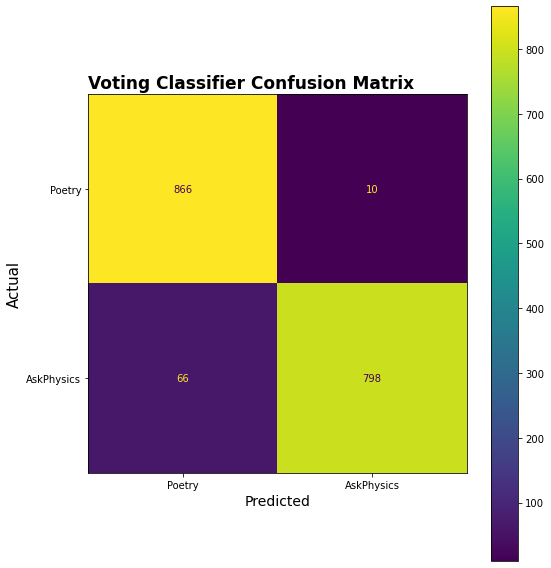

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
metrics.plot_confusion_matrix(gs_vote, X_test_stem, y_test_stem, ax=ax,
                              display_labels=['Poetry', 'AskPhysics'])
ax.set_title('Voting Classifier Confusion Matrix', 
                loc='left', fontweight='bold', fontsize=17)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Actual', fontsize=15)
plt.tight_layout();
fig.savefig('./graphics/voting_classifier_confusion_matrix.png')

**Interpretation**

The above figure is the confusion matrix for the Voting Classifier ensemble model. The matrix shows that overall the model is good at predicting AskPhysics submissions, however, the model is has substantially worse at predicting poetry. This is problematic as some words may be more strongly associated with poetry and therefore emotions than should be.

## Evaluating Features

In [44]:
importance_dfs = []
for estimator, name in zip(gs_vote.best_estimator_.estimators_, 
                           ['ada', 'gb', 'rf']):
    importance_dfs.append(pd.DataFrame({'importance': 
                                        estimator.named_steps[name]\
                                        .feature_importances_},
                             index=estimator.named_steps['tfidf']\
                                       .get_feature_names()))

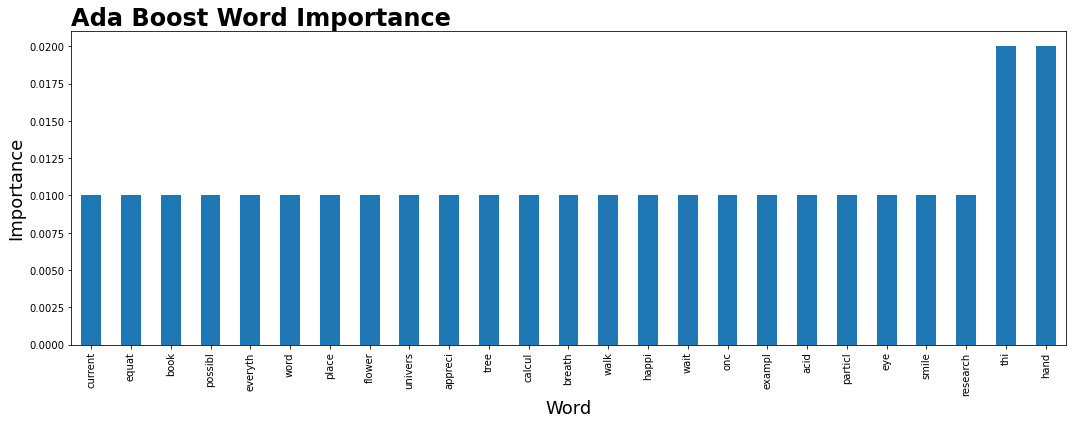

In [45]:
plt.figure(figsize=(15, 6))
importance_dfs[0]['importance'].sort_values()[-25:].plot(kind='bar')
plt.title('Ada Boost Word Importance', 
          fontweight='bold', fontsize='24', loc='left')
plt.xlabel('Word', fontsize=18)
plt.ylabel('Importance', fontsize=18)
plt.tight_layout();

**Interpretation**

The above figure is a barchart of the top 25 words, by importance used to classify the submission subreddit within the ada boost model. Compared to the other models the importances seem much more uniform.

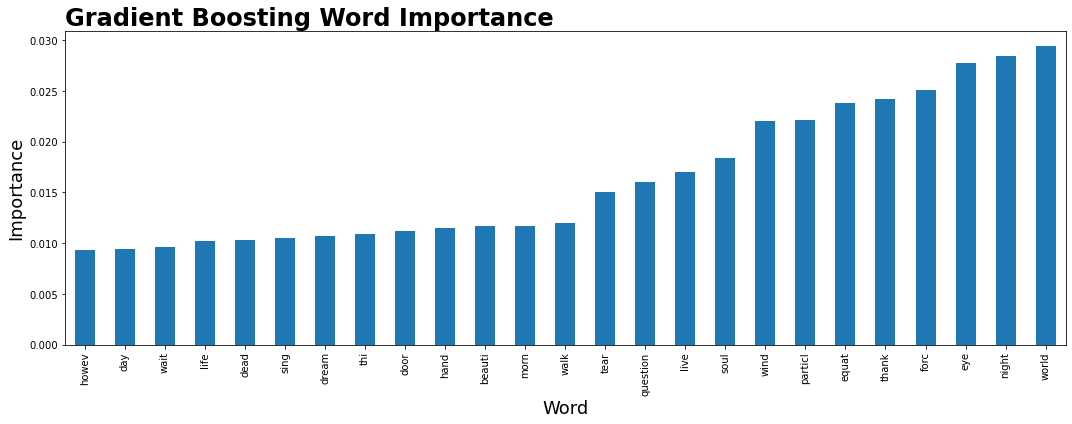

In [46]:
plt.figure(figsize=(15, 6))
importance_dfs[1]['importance'].sort_values()[-25:].plot(kind='bar')
plt.title('Gradient Boosting Word Importance', 
          fontweight='bold', fontsize='24', loc='left')
plt.xlabel('Word', fontsize=18)
plt.ylabel('Importance', fontsize=18)
plt.tight_layout();
plt.savefig('./graphics/gradient_boosting_feature_importance.png')

**Interpretation:**
    
The above figure is a barchart of the top 25 words, by importance used to classify the submission subreddit within the gradient boosting model. Words seem to have a heavy skew of importance, especially the world life.

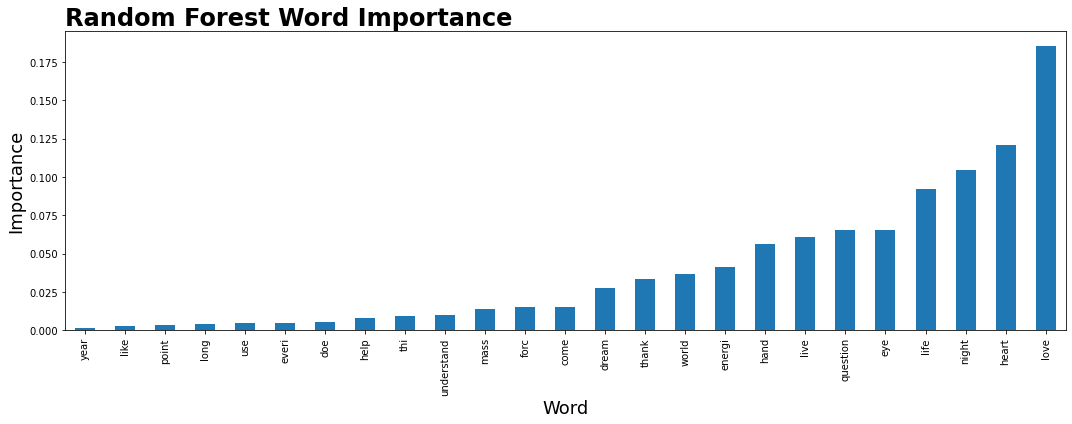

In [47]:
plt.figure(figsize=(15, 6))
importance_dfs[2]['importance'].sort_values()[-25:].plot(kind='bar')
plt.title('Random Forest Word Importance', 
          fontweight='bold', fontsize='24', loc='left')
plt.xlabel('Word', fontsize=18)
plt.ylabel('Importance', fontsize=18)
plt.tight_layout();
plt.savefig('./graphics/random_forest_feature_importance.png')

**Interpretation:**
    
The above figure is a barchart of the top 25 words, by importance used to classify the submission subreddit within the random forest model. Words seem to have an even heavy skew of importance although each model seems to have some variation in the words that are important

**Key Issue**

Overall all graphs show a a relatively small list of words that carry a significant importance within the model. The lack of words points to a need to use many features if we want many words as a result. This methodology of getting a list of emotive words does not scale well with our modeling as we do not want to overburden the models with features.

## Results & Conclusion

The Voting Classifier ensemble model best predicted the subreddit of the submission based on the words within the body of the submission, scoring ~0.06 better on mean accuracy than the closest model, random forest classifier. The training score was below the cross val score, which may mean the model is not overfit, but the fact that the training score is is consistently lower than the cross val score is odd. There may be unaccounted for leakage occurring.

Overall the score was much better than the ~0.50 mean accuracy of the baseline and implies that there is a clear separation between the wording in submissions in /r/poetry and /r/AskPhysics, as expected. However, even with a well scoring model compiling a list of meaningful words is still difficult. Using feature importance we are still very limited in the amount of words that we can select as more features do not mean a better model. Additionally, the model performed better on unigrams and therefore means getting a phrase of words is difficult. Only selecting single words seems to remove all context.

If we were to continue with classification models. Next steps could include expanding our base dataset to include many more subreddits such as /r/history, /r/mathematics, /r/askscience, and other science subreddits which contain largely text submissions. Another step would be to build the classification models while rotating features and selecting the high scoring models to pull features from, however, it may be best to search for other modeling solutions due to the contradictory need to reduce model features and the desire to create a large and robust library of emotive words.